In [82]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib #as mpl

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


## settings
# min_days: only use counties which have data for the last min_days
# max_frac_missing: after filtering by min_days, only keep features with at most max_frac_missing
# is_pop_scale: whether to scale cases by population
# use_rel_counts: whether to pred counts/pop_size
# use_log_counts: whether to use log(counts), or log(counts/pop), as features and target
# use_counts_only # whether to use only counts as features (not used here since i try both)

cases_or_deaths = 'cases'
min_days = 0  #28
max_frac_missing = 0.1
use_rel_counts = False
use_log_counts = False
#use_counts_only = False



## Load data into pd dataframes ##

# Replace non-ascii chars in files (some county names have accent mark)
counts_f = 'data/nyt-us-counties-cases-deaths.csv'
with open(counts_f) as f:
    lines = f.readlines()
with open(counts_f,'w') as f: # overwrite old file
    for line in lines:
        f.write(''.join([c if ord(c) < 128 else '_' for c in line]) )

# nyt case and death counts, where each date-county pair is a row
nyt_counts_df = pd.read_csv(counts_f)
nyt_counts_df['date'] = pd.to_datetime(nyt_counts_df['date'])

# load additional county-level data to use as features
interventions_df = pd.read_csv('data/jieyingwu_dates_interventions.csv') # ordinal dates
demographics_df = pd.read_csv('data/jieyingwu_demographics_counties.csv') # pop size, income, temp, etc


# make pivot df where each county is a row, with dates as columns
cases_df = pd.pivot_table(nyt_counts_df, values = 'cases', index=['fips','county','state'], columns = 'date').reset_index()
county_cols = cases_df.iloc[:,:3].copy()


# merge in additional features (case/death counts will be rightmost columns)
cases_df = interventions_df.merge(cases_df, left_on='FIPS', right_on='fips', suffixes=('_interventions', '_cases')) 
cases_df = demographics_df.merge(cases_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

#  # first 3 cols will be fips, county, state. rest are numeric data
not_fips_mask = [str(c).lower() != 'fips' for c in cases_df.columns]
cases_df = cases_df.loc[:,not_fips_mask] # remove redundant fips
cases_df = cases_df.select_dtypes(include='number') # numeric features only
cases_df = county_cols.join(cases_df)

# repeat for deaths
deaths_df = pd.pivot_table(nyt_counts_df, values = 'deaths', index=['fips','county','state'], columns = 'date').reset_index()
deaths_df = interventions_df.merge(deaths_df, left_on='FIPS', right_on='fips',suffixes=('_interventions', '_deaths')) 
deaths_df = demographics_df.merge(deaths_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

not_fips_mask = [str(c).lower() != 'fips' for c in deaths_df.columns]
deaths_df = deaths_df.loc[:,not_fips_mask] # remove redundant fips
deaths_df = deaths_df.select_dtypes(include='number') # numeric features only
deaths_df = county_cols.join(deaths_df)



In [36]:


## filter counties and features with missing data

X_df = None        # X_df will contain only counties and features which pass filters
if cases_or_deaths == 'cases':
    X_df = cases_df.copy()
else:
    X_df = deaths_df.copy()

counts_mask = [str(c)[:5] == '2020-' for c in X_df.columns] # bool which cols are counts

if use_rel_counts:
    pop_estimates = X_df['POP_ESTIMATE_2018'].values[:,None]
    X_df.iloc[:,counts_mask] = np.divide(1.0*X_df.iloc[:,counts_mask].values, pop_estimates)
    
if use_log_counts:
    X_df.iloc[:,counts_mask] = np.log(1.0*X_df.iloc[:,counts_mask].values)


# keep counties which have data from past 28 (or 0, etc) days
end = X_df.columns[-1] # target is last day
start = end - pd.DateOffset(min_days)
X_df = X_df[~X_df.loc[:,start:end].isna().any(axis=1)]

# keep columns which are >10% missing (lose a lot of prev dates if not filtering counties first)
keep_cols = X_df.columns[X_df.isnull().mean() < max_frac_missing]
X_df = X_df[keep_cols] 

# make target y (last day) and exclude from X_df
y = X_df.iloc[:,-1].values
y = y.reshape((-1,1))

X_df = X_df.iloc[:,:-1]
X_df # first 3 cols are fips,county,state, up



,fips,county,state,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,...,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,2020-04-09 00:00:00,2020-04-10 00:00:00,2020-04-11 00:00:00,2020-04-12 00:00:00,2020-04-13 00:00:00,2020-04-14 00:00:00,2020-04-15 00:00:00
0,1001.0,Autauga,Alabama,2.0,2.0,0.0,55601,158.0,655.0,532.0,...,12.0,12.0,12.0,17.0,17.0,19.0,19.0,19.0,23.0,25.0
1,1003.0,Baldwin,Alabama,3.0,2.0,5.0,218022,5403.0,2254.0,2228.0,...,38.0,42.0,49.0,59.0,59.0,66.0,71.0,78.0,87.0,98.0
2,1005.0,Barbour,Alabama,6.0,6.0,3.0,24881,-277.0,261.0,324.0,...,3.0,3.0,3.0,7.0,9.0,10.0,10.0,10.0,11.0,13.0
3,1007.0,Bibb,Alabama,1.0,1.0,0.0,22400,-155.0,250.0,256.0,...,7.0,8.0,9.0,11.0,11.0,13.0,16.0,17.0,17.0,19.0
4,1009.0,Blount,Alabama,1.0,1.0,0.0,57840,13.0,681.0,662.0,...,10.0,10.0,10.0,11.0,12.0,12.0,13.0,15.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,56035.0,Sublette,Wyoming,9.0,10.0,2.0,9813,54.0,97.0,60.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2718,56037.0,Sweetwater,Wyoming,5.0,8.0,2.0,43051,-496.0,546.0,303.0,...,5.0,6.0,5.0,6.0,6.0,7.0,7.0,9.0,9.0,10.0
2719,56039.0,Teton,Wyoming,7.0,8.0,5.0,23081,-180.0,230.0,75.0,...,40.0,44.0,39.0,50.0,50.0,53.0,56.0,56.0,57.0,59.0
2720,56041.0,Uinta,Wyoming,7.0,8.0,2.0,20299,-157.0,276.0,147.0,...,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [45]:
## try linear model using prev counts in same county (whatever days left after filtering)
# now filter down X_df to counts
# TODO try predicting next day each county using prev day or week ago data from other counties

# X is array of features, will correspond to 'data'
# y is array 'target'

 # pd slicing includes last index
counts_mask = [str(c)[:5] == '2020-' for c in X_df.columns]
Xcounts_df = X_df.iloc[:,counts_mask]
X = Xcounts_df.values

# mask counties with missing values. would mask counties with missing y here
mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1) & ~np.isneginf(X).any(axis=1) 

# fit
regr = linear_model.LinearRegression() 
regr.fit(X[mask], y[mask])



def printTopCoefs(values, columns, nTop=None, includeBottom=False, maxPad=70):
    '''given values and corresponding descriptions in order, print top values'''
    col_valuesL = list( zip(list(columns), values.flatten().tolist()) )
    col_valuesL.sort(key=lambda tup: abs(tup[1]), reverse=True)

    p = max( [len(str(c)) for c in columns] ) + 1 # padding for print
    p = min(p, maxPad)
    if nTop == None:
        nTop = len(columns)
    for col, effect in col_valuesL[:nTop]:
        print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    if includeBottom and nTop*2 > len(columns): 
        # print remaining entries without duplicates
        for col, effect in col_valuesL[nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    elif includeBottom:
        print('...')
        for col, effect in col_valuesL[-nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )        
    return


# print top coefficients - as expected, prev day has biggest effect
print('# Linear model on log(cases), using previous days counts')
printTopCoefs(regr.coef_, Xcounts_df.columns, nTop=None, includeBottom=True)



# Linear model on log(cases), using previous days counts
2020-04-15 00:00:00 	   0.89673
2020-04-14 00:00:00 	   0.40543
2020-04-07 00:00:00 	  -0.12827
2020-04-13 00:00:00 	  -0.10722
2020-04-09 00:00:00 	   0.07210
2020-04-11 00:00:00 	  -0.06267
2020-04-08 00:00:00 	  -0.04587
2020-04-10 00:00:00 	  -0.03000
2020-04-06 00:00:00 	  -0.00875
2020-04-12 00:00:00 	   0.00048


In [46]:

## linear model: target against demographics, interventions, and counts in same county on previous days
# remake x_df to include these additional features
X = X_df.iloc[:,3:].values

# mask counties with missing values
# can also mask counties w missing y here
mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1) & ~np.isneginf(X).any(axis=1) 


regr = linear_model.LinearRegression() 
regr.fit(X[mask], y[mask])

#preds = regr.predict(test_data)
print('# Linear model of log(cases) using demographics, interventions, previous days counts')
printTopCoefs(regr.coef_, X_df.iloc[:,3:].columns, nTop=10, includeBottom=True)

# overfitting
# ex/ using data up to april 12, top 3 coefficients land area, water area, total area with coefs +/- 52


# Linear model of log(cases) using demographics, interventions, previous days counts
Fraction of Active Physicians Who Are International Medical Graduates (IMGs) 2018 (AAMC)	 -19.00876
Area in square miles - Land area                                      	  14.22557
Area in square miles - Total area                                     	 -14.22539
Area in square miles - Water area                                     	  14.22469
Fraction of MD Students Matriculating In-State AY 2018-2019 (AAMC)    	   9.70359
Fraction of Active Physicians Who Are Female 2018 (AAMC)              	   8.60618
Fraction of Residents in ACGME Programs Who Are IMGs as of December 31 2018 (AAMC)	  -7.29149
Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)	  -6.30841
Fraction of Physicians Retained in State from Undergraduate Medical Education (UME) 2018 (AAMC)	  -3.75639
Active General Surgeons per 100000 Population 2018 (AAMC)             	   3.70280
...
MEDHHINC_2018                       

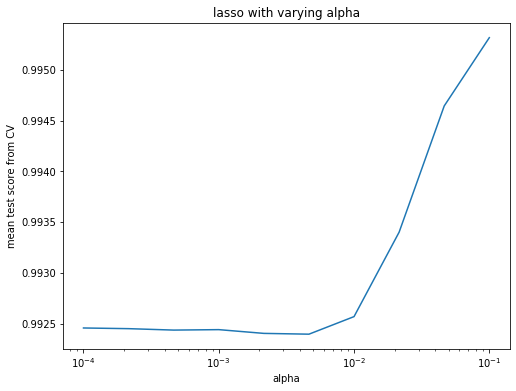

In [41]:
# try lasso
# choose alpha with cv (takes a few min, doesn't converge within 1000 iter)
# note: faster if random selecting coef to update, but less smooth. alpha = 1 was still best

regr = linear_model.Lasso(alpha=1.0, max_iter=5000,selection='cyclic')

alphas = np.logspace(-4, -1, 10)
tuned_parameters = [{'alpha': alphas}]
n_folds = 4

clf = model_selection.GridSearchCV(regr, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X[mask], y[mask])
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize=(8,6))
plt.semilogx(alphas, scores)
ax.set_title('lasso with varying alpha')
ax.set_ylabel('mean test score from CV')
ax.set_xlabel('alpha')
plt.show()  


In [64]:
# lasso, continued

# highest test score was at alpha = 1
# compare small, large alpha, and positive only
# note that increasing the iterations can change the coefficients pretty dramatically

coef_names = X_df.columns[3:]


print('# LASSO')
print('# varying max_iter at alpha=1.0')

regr = linear_model.Lasso(alpha=1.0,max_iter=5000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0 (L1), run for only 5k iter)')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)

regr = linear_model.Lasso(alpha=1.0,max_iter=15000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0, run for 15k iter')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)


regr = linear_model.Lasso(alpha=1.0,max_iter=50000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0, run for 50k iter')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)


print('\n# LASSO, positive restrain or low alpha')

regr = linear_model.Lasso(alpha=1.0, max_iter=15000, positive=True)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0 and positive restraint, run for 15k iter')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)


regr = linear_model.Lasso(alpha=0.0001, max_iter=15000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 0.0001, run for 50k iter')
printTopCoefs(regr.coef_,coef_names, nTop=10, includeBottom=False)


    


# LASSO
# varying max_iter at alpha=1.0

# alpha = 1.0 (L1), run for only 5k iter)
Radiology & Diagnostic Radiology (AAMC)                               	   0.79915
Pediatrics** (AAMC)                                                   	  -0.78265
Obstetrics & Gynecology Primary Care (2019)                           	   0.63584
Emergency Medicine specialists (2019)                                 	   0.50639
Surgery specialists (2019)                                            	   0.50518
Pediatrics Primary Care (2019)                                        	   0.47754
Emergency Medicine (AAMC)                                             	  -0.36033
2020-04-14 00:00:00                                                   	   0.34650
Economic_typology_2015                                                	   0.33707
2020-04-13 00:00:00                                                   	   0.32244

# alpha = 1.0, run for 15k iter
2020-04-15 00:00:00                                             

Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=801.721, BIC=815.464, Time=0.028 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=822.001, BIC=826.582, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=814.612, BIC=821.484, Time=0.014 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=810.690, BIC=817.561, Time=0.015 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=820.573, BIC=822.864, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=812.431, BIC=823.884, Time=0.025 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=807.282, BIC=818.735, Time=0.023 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=804.951, BIC=820.985, Time=0.029 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=803.258, BIC=819.292, Time=0.033 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=812.261, BIC=821.423, Time=0.020 seco

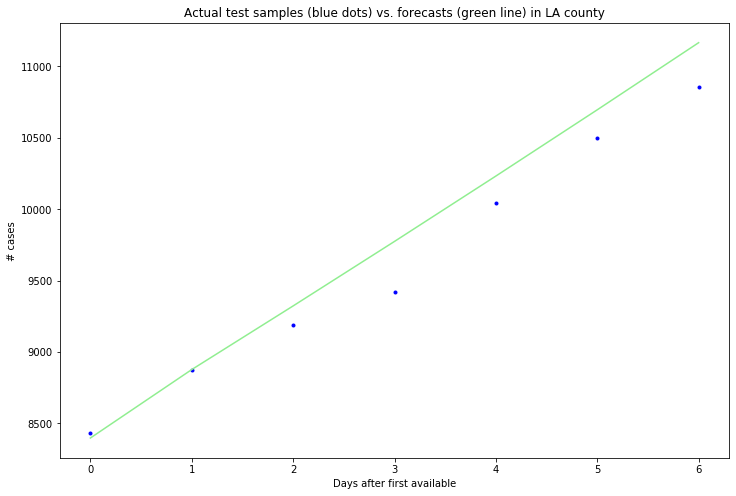

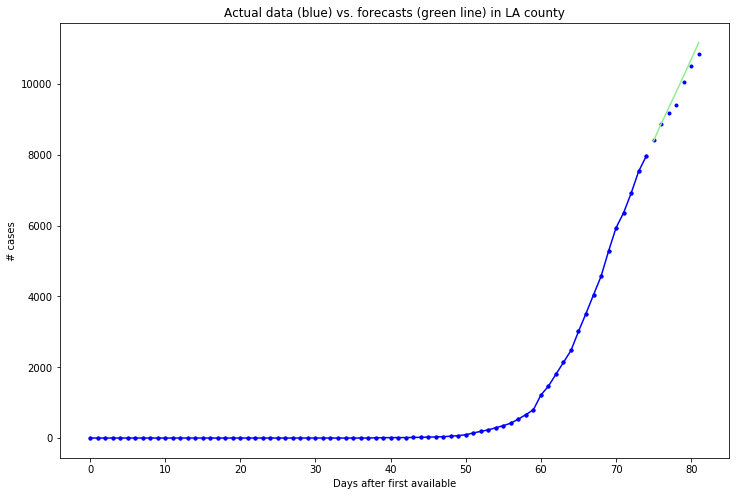

In [83]:
## arima model, fitting each county individually
# TODO combine arima with OLS? or arimax? 
# https://stats.stackexchange.com/questions/418259/arimax-vs-regression-with-arima-errors
# TODO add other counties as additional times series features
# TODO add test coverage as additional times series feature
# TODO run on multiple counties and average performance in terms of MSE, plot each curve

import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt


# Load and fit count data for a single county at a time

i = int(np.where(cases_df['fips'] == 6037)[0]) # only do LA for now
counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]
if cases_or_deaths == 'cases':
    data = np.array(cases_df.iloc[i,counts_mask].values, dtype='float')
else:
    data = np.array(deaths_df.iloc[i,counts_mask].values, dtype='float')
    
    
# data should be a 1d array of counts over time
first_nonmiss = np.where(~np.isnan(data))[0][0]
data = data[first_nonmiss:] 


train, test = model_selection.train_test_split(data, test_size=7) # test on last week

# fit model -- auto_arima automatically chooses parameters if not specified. can slow if d not set
arima_fitted = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, m=1)


print('Selected ARIMA order', arima_fitted.get_params()['order'])

# forecast
forecasts = arima_fitted.predict(n_periods=test.shape[0])  # predict N steps into the future

# Plot actual test vs. forecasts
x = np.arange(test.shape[0])  # here, x is date
plt.scatter(x, test, marker='.', color = 'blue')
plt.plot(x, forecasts, color = 'lightgreen')
plt.title('Actual test samples (blue dots) vs. forecasts (green line) in LA county')
plt.xlabel('Days after first available')
if use_log_counts:
    plt.ylabel('log( %s )' % cases_or_deaths)
else:
    plt.ylabel('# %s' % cases_or_deaths)
plt.show()



# same, but showing training data too
x = np.arange(data.shape[0])
plt.scatter(x, data, c='blue', marker='.')
plt.plot(x[:-7], train, c='blue', marker='.') # train line
plt.plot(x[-7:], forecasts, c='lightgreen') # forecast line
plt.title('Actual data (blue) vs. forecasts (green line) in LA county')
plt.xlabel('Days after first available')
if use_log_counts:
    plt.ylabel('log( %s )' % cases_or_deaths)
else:
    plt.ylabel('# %s' % cases_or_deaths)
plt.show()



In [ ]:
## prophet: bayesian curve fitting 
# this cell wip
# need to check if intended primarily for seasonal data
## has linear and logistic growth models



from fbprophet import Prophet
# https://facebook.github.io/prophet/docs/

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=??)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# TODO add proportion or number tested as feature
# state-level data available here, including time series starting from feb 28:
# https://covidtracking.com/data

#endogenous: response, dependent
#exogenous: predictor, independent




In [69]:
# convert dates to numbers for plt
#x = matplotlib.dates.date2num(train_cases_df.columns[3:])

## linear model: regress log(deaths or cases) against demographics + interventions + counts
## linear model: regress log(deaths) against deaths in all counties on previous days
#            maybe too few sample - coeffs would be different for pred LA vs other county
# also try predicting raw deaths, increase in deaths, deaths per pop size
## rf, arima, curve fitting

## regression, arimax model. 
# delta log(cases_county_x) = beta * X_demographic + phi_(t-1) * cases_(all counties, t-1) + ....